## Predicting Item Churn with Amazon Product Dataset

# Predicting Customer Churn with getML on Amazon Product Dataset

## Introduction
This notebook showcases how to use [getML](https://getml.com) to predict item churn with the [Amazon e-commerce dataset](https://relbench.stanford.edu/datasets/rel-amazon/#item-churn).
The goal is to demonstrate how even a simple, untuned getML model can outperform competing approaches on real-world, multi-table datasets with minimal effort.

### Why use getML FastProp?
- *Relational Learning.* FastProp (short for Fast Propositionalization) extracts features from related tables without manual SQL or deep business domain expertise.
- *Blazing Fast.* FastProp runs [60 to 1000 times faster](https://github.com/getml/getml-community?tab=readme-ov-file#benchmarks) than alternatives like [featuretools](https://www.featuretools.com) or [tsfresh](https://tsfresh.com), scaling easily to millions of rows.
- *Superior Performance.* FastProp frequently outperforms graph neural networks and models with handcrafted features on relational learning tasks.

The Amazon Product dataset consists of:
- 3 Tables (Customers, Product, Review)
- 16 Columns in total
- ~23 million rows

This dataset is part of the [Relational Deep Learning Benchmark (RelBench)](http://relbench.stanford.edu/),
maintained at Stanford, which standardizes relational learning tasks.

### Outline

1. [Setup](#1.-Setup)
2. [Loading Data into getML, Inspecting, and Setting Roles (Data Annotation)](#2.-Loading-Data-into-getML,-Inspecting,-and-Setting-Roles-(Data-Annotation))
3. [Define the getML DataModel](#3.-Defining-the-getML-DataModel)
4. [Create a getML Container referncing the Data](#4.-Creating-a-getML-Container-referencing-the-Data)
5. [Define the Pipeline and Check the Data](#5.-Defining-the-getML-Pipeline-and-Checking-the-Data)
6. [Fitting and Scoring the Pipeline](#6.-Fitting-and-Scoring-the-getML-Pipeline)
7. [Explore Feature Importances](#7.-Feature-Importances)
8. [Explore Column Importances](#8.-Column-Importances)

---
## 1. Setup

> <span style="font-weight: 500; color: #3b3b3b;">ⓘ️&nbsp; Note</span>
>
> We have prepared an [environment with all necessary dependencies](pyproject.toml) for you. To to use it, just start jupyter lab through `uv run jupyter lab` from the repository root.

In this section, we:
- Import required libraries.
- Create a getML project.
- Download the "Amazon" dataset from RelBench.
- 
The "rel-amazon" dataset represents relational data on sales history,
and the "item-churn" task focuses on predicting item churn.

In [ ]:
import getml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from relbench.datasets import get_dataset
from relbench.tasks import get_task

# Enable textual output to avoid rendering issues in certain JupyterLab environments
getml.utilities.progress.FORCE_TEXTUAL_OUTPUT = True
getml.utilities.progress.FORCE_MONOCHROME_OUTPUT = True

# Launch getML engine and set project.
getml.set_project("az-item-churn")

# Download dataset and task from RelBench.
dataset = get_dataset("rel-amazon", download=True)
task = get_task("rel-amazon", "item-churn", download=True)

  Loading pipelines... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00


Connected to project 'az-item-churn'.

---
## 2. Loading Data into getML, Inspecting, and Setting Roles (Data Annotation)

> <span style="font-weight: 500; color: #3b3b3b;">ⓘ️&nbsp; Note</span>
>
> While the `relbench` library provides a high-level API to load datasets and tasks into pandas dataframes,
> we will use getML's native `DataFrame` API to load the data directly into getML to speed up the process.

The Amazon item-churn dataset is provided by relbench as a [dataset](https://relbench.stanford.edu/start/) of multiple tables:
- `product`
- `review`
- `customer`

The target variable `churn` is provided as a [task](https://relbench.stanford.edu/start/). In getML, we
refer to table containing the target variable as the [population table](https://getml.com/latest/user_guide/concepts/data_model/#the-population-table):
- population (train/test/val splits) with the target variable `churn`

### Objectives:
- Load each table from disk
- Inspect columns to understand the schema
- Assign appropriate roles (join_key, time_stamp, numerical, categorical, etc.)

### Why Roles Matter
[`Roles`](https://getml.com/latest/user_guide/concepts/annotating_data/#annotating-data-roles) allow getML to:
- Efficiently encode links between tables (`join_key`)
- Interpret timestamps for time-aware modeling (`time_stamp`)
- Encode numerical, categorical, and text features (`numerical`, `categorical`, `text`)
- Ignore irrelevant columns (`unused_float` or `unused_string`)


### a. Product Table

In [2]:
product_df = pd.read_parquet(f"{dataset.cache_dir}/db/product.parquet")

# Inspect the structure of the product table
product_df


,product_id,category,brand,title,description,price
0,0,"[Books, Literature & Fiction, Dramas & Plays]",Visit Amazon's William Shakespeare Page,Love's Labour's Lost: Performed by Derek Jacob...,William Shakespeare is widely regarded as the ...,20.93
1,1,"[Books, Children's Books, Literature & Fiction]",Louis (ed) UNTERMEYER,The golden treasury of poetry,Collection of Poetry,23.98
2,2,"[Books, Mystery, Thriller & Suspense]",Visit Amazon's Agatha Christie Page,The Blue Geranium (Miss Marple),None,8.82
3,3,"[Books, Humor & Entertainment]",Visit Amazon's Tom Baker Page,Who on Earth Is Tom Baker?,Tom Baker's autobiography covers his childhood...,159.95
4,4,"[Books, Christian Books & Bibles, Bible Study ...",Visit Amazon's Clarence Larkin Page,The Greatest Book on &quot;Dispensational Trut...,The Greatest Book on Dispensational Truth in t...,44.76
...,...,...,...,...,...,...
506007,506007,None,"Tricia & Putman, Cara Goyer",Mason Jar Mayhem,"Spring has come to Sugarcreek, and the communi...",15.05
506008,506008,None,Author,The Little Book of Pussy (2013-06-16) [Paperback],From the time The Big Penis Book was published...,17.00
506009,506009,None,,The Age of Not Believing: A Christmas Tale by ...,None,42.93
506010,506010,None,,The Charlies Angels' Casebook,None,17.87


In [3]:

# The category column contains lists with product categories. In that format the information is not accessible to feature learning. 

# For expediency, we simply pick the first informative element of the list and store it in a new column `category_level_2`.
# To keep preprocessing simple, we will drop the columns `brand`, `title`, and `description`.

product_df["category"] = product_df["category"].apply(
    lambda x: x.tolist() if isinstance(x, np.ndarray) else (x or [])
)

product_df["category_level_2"] = product_df["category"].apply(
    lambda arr: arr[1] if len(arr) > 1 else None
)


# Role assignment breakdown on `customer`:
# - `product_id`: Acts as the primary key, linking to other tables → `join_key`
# - `price`: Numerical data representing product price → `numerical`
# - `category_level_2`: Categorical data → `categorical`


## roles for the product table
product_roles = getml.data.Roles(
    join_key=["product_id"],
    numerical=["price"],
    categorical=["category_level_2"]
)

product_df = product_df.drop(columns=["category","brand","title","description"])


product = getml.DataFrame.from_pandas(product_df,
    name = 'product',
    roles = product_roles
)



### b. Review Table

In [4]:

review_base = getml.data.DataFrame.from_parquet(f"{dataset.cache_dir}/db/review.parquet", name = 'review')


In [5]:

## roles for the review table
review_base.set_role(["product_id","customer_id"], getml.data.roles.join_key)
review_base.set_role("review_time", getml.data.roles.time_stamp)
review_base.set_role("rating", getml.data.roles.numerical)


review_all = review_base.with_role(["verified"], getml.data.roles.categorical)

/home/jan-meyer/Documents/github/monorepo/src/python-api/getml/data/columns/columns.py:1837: UserWarning: After parsing time stamps, column 'review_time' likely contains only nan values.

Check the supplied 'time_formats' and the data.
  warnings.warn(


### c. Customer Table

In [6]:
# The customer table only contains the `customer_id` column and the customer's `name`. It is intuitive to assume that customers` names are non-informative for predicting item churn. We will therefore ignore the entire customer table.

# customer = getml.data.DataFrame.from_parquet(f"{dataset.cache_dir}/db/customer.parquet", name = 'customer')

# customer

### d. Population tables  (train, test, val)

The population table holds the statistical population for the inference task at hand. Thus,
it is the table that holds the target variable, the possible reference dates (to prevent data leakage),
and is split into train, test, and validation sets. The population table is the canonical table data
scientist are used to work with in "classical", tabular machine learning tasks. It is the table that will be
handed over to the machine learning algorithm for training and prediction, and therefore is the target
entity for the feature learning process.

As we were loading the relbench task, the population table is already split into train, test, and val and contains
nothing else than the target variable (`churn`), the primary key (`product_id`), and the reference date (`timestamp`). Accordingly,
we assign the following roles:
- `product_id` is the join key.
- `churn` is the target variable.
- `timestamp` represents the prediction or cut-off date to prevent data leakage.

In [7]:
population_roles = getml.data.Roles(
    join_key=["product_id"],
    target=["churn"],
    time_stamp=["timestamp"],
)

In [8]:
population_roles = getml.data.Roles(
    join_key=["product_id"], target=["churn"], time_stamp=["timestamp"]
)

train = getml.data.DataFrame.from_parquet(
     f"{task.cache_dir}/train.parquet", "train", population_roles
)

val = getml.data.DataFrame.from_parquet(
     f"{task.cache_dir}/val.parquet", "val", population_roles
)

test = getml.data.DataFrame.from_parquet(
     f"{task.cache_dir}/test.parquet", "test", population_roles
)

---
## 3. Defining the getML DataModel

In getML, the [`DataModel`](https://getml.com/latest/user_guide/concepts/data_model/) serves as the foundation for relational feature learning. The DataModel acts as the search space for features, similar to the schema of a relational database. It defines the universe of possible feature paths that getML’s algorithms can explore and learn from.

The data model is structured as a Directed Acyclic Graph, where each [join path](https://getml.com/latest/user_guide/concepts/data_model/#joins) represents a potential feature learning route. This structure enables automatic extraction of predictive signals (features) from complex, multi-table datasets.

Trivial joins ([one-to-one](https://getml.com/latest/reference/data/relationship/#getml.data.relationship.one_to_one) or [many-to-one](https://getml.com/latest/reference/data/relationship/#getml.data.relationship.many_to_one)) onto the population don’t produce new feature learning routes but columns in such tables are added to the main table _as is._ So, these paths are useful for enriching data but aren’t part of the feature learning process.

### Amazon DataModel Overview
<img src="https://relbench.stanford.edu/img/rel-amazon.png" width="500"/>

* The primary feature learning path is the [*one-to-many* relationship](https://getml.com/latest/reference/data/relationship/#getml.data.relationship) between the `population` table and the `review` table. This is where most valuable features are derived.
* The `product` table enriches the `population` and `review` tables, through trivial joins and introduces new feature learning paths, that the feature learner can aggregate over. The `customer` table is dropped since it is not conceivable that information is encoded in the customer's name.

#### Key Concepts:
* The [`DataModel`](https://getml.com/latest/user_guide/concepts/data_model/) is abstract. It defines the relational structure but does not contain any data itself.
* [`Placeholders`](https://getml.com/latest/user_guide/concepts/data_model/#placeholders) represent tables in the model. These placeholders mirror the schema of actual DataFrames but are decoupled from raw data until the point of training.

In [9]:
# 1. Derive the population placeholder from the “train” DataFrame in our populations dict.
#    These rows form our target population for learning and prediction (we could
#    also use val or test here, as those share the same schema).
dm = getml.data.DataModel(population=train.to_placeholder())

# 2. Add placeholders for product and review tables.
#    These tables hold valuable information relevant to predictions.
#    Without this step, the predictor cannot access the knowledge within
#    these tables, leading to poorer model performance.
dm.add(    product.to_placeholder(), 
    review_all.to_placeholder("review_all"), 
    review_base.to_placeholder("review_customer"),
    review_base.to_placeholder("review_recent"),
    )

# 3. Specify relational links:
#    - population -> product on "product id" (many-to-one)
#    - population -> review_recent on "product_id" with time_stamps to prevent data leakage
#    - population -> review on "product_id" with time_stamps to prevent data leakage
#    - population -> review_all on "product_id" with time_stamps to prevent data leakage
#    - review_all -> review_customer on "customer_id" with time_stamps to prevent data leakage
#    - review_customer -> product on "product_id" (many-to-one)
dm.population.join(
    dm.product, on="product_id", relationship=getml.data.relationship.many_to_one
)

dm.population.join(
    dm.review_recent, on="product_id", time_stamps=("timestamp", "review_time"),
    memory = getml.data.time.days(365)
)

dm.population.join(
    dm.review_all, on="product_id", time_stamps=("timestamp", "review_time")
)

dm.review_all.join(
    dm.review_customer, on="customer_id", time_stamps=("review_time", "review_time")
)

dm.review_customer.join(
    dm.product, on="product_id", relationship=getml.data.relationship.many_to_one
)

dm

,data frames,staging table
0,"train_short, product",TRAIN_SHORT__STAGING_TABLE_1
1,review_all,REVIEW_ALL__STAGING_TABLE_2
2,"review_customer, product",REVIEW_CUSTOMER__STAGING_TABLE_3
3,review_recent,REVIEW_RECENT__STAGING_TABLE_4


---
## 4. Creating a getML Container referencing the Data

The [`Container`](https://getml.com/latest/reference/data/container/#getml.data.Container) holds _all_ data (i.e. population, split into train, test, val, _and_ all peripheral tables: customer, transaction, article).
The actual data in a container will be linked to the abstract [**DataModel**](https://getml.com/latest/reference/data/data_model/) during training.

Why a Container is an important construct:
- `Container` is a convenience API that eases handling of relational data for Machine Learning tasks
- The DataModel defines the relational structure; the Container holds references to the actual data.
- During `pipeline.fit(container.train)`, the Container maps [*data*](https://getml.com/latest/reference/data/data_frame/) to [*placeholders*](https://getml.com/latest/reference/data/placeholder/),
  allowing getML to apply relational joins and time constraints for feature learning.
- No data is duplicated – the Container references the original tables, ensuring efficiency.
- A container allows you to easily pass around relational datasets for training, validation, and testing: E.g. `container.train` holds a [Subset](https://getml.com/latest/reference/data/subset/) that contains the training data for the population and all related peripheral tables.

This separation enhances reproducibility and keeps data handling modular.

In [10]:

# The constructor of the container receives the population tables (in this case already split into train, test, val)
container = getml.data.Container(train=train, val=val, test=test)

# `add` adds peripheral tables to the container
container.add(product, review_all=review_all, review_customer=review_base, review_recent=review_base)

# Display the container to verify all splits and tables are correctly loaded.
container

,subset,name,rows,type
0,train,train_short,10000,DataFrame
1,test,test,166842,DataFrame
2,val,val,177689,DataFrame
,alias,name,rows,type
0,product,product,506012,DataFrame
1,review_all,review_short,10000,View
2,review_customer,review_short,10000,DataFrame
3,review_recent,review_short,10000,DataFrame


In [11]:
pipe = getml.Pipeline(
    tags=["base_pipeline"],
    data_model=dm,
    feature_learners=[getml.feature_learning.FastProp(
        n_most_frequent=0,
        num_features=1000,
        aggregation=(
            getml.feature_learning.FastProp.agg_sets.default 
        ),
    )],
    predictors=[getml.predictors.XGBoostClassifier(max_depth = 5)],
    loss_function=getml.feature_learning.loss_functions.CrossEntropyLoss,
)

# .check(...) does an analysis on the pipeline, data model and container
# to see if everything is consistent (time relationships, roles, table joins, etc.).
# We pass the 'train' subset for verification
pipe.check(container.train)

Checking data model...

  Staging... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00

  Staging... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00
  Checking... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00


The pipeline check generated 0 issues labeled INFO and 7 issues labeled WARNING.

,type,label,message
0,WARNING,COLUMN SHOULD BE UNUSED,100.000000% of all entries in column 'review_time' in REVIEW_ALL__STAGING_TABLE_2 are NULL values. You should consider setting its role to unused_float.
1,WARNING,COLUMN SHOULD BE UNUSED,100.000000% of all entries in column 'review_time' in REVIEW_CUSTOMER__STAGING_TABLE_3 are NULL values. You should consider setting its role to unused_float.
2,WARNING,COLUMN SHOULD BE UNUSED,100.000000% of all entries in column 'review_time' in REVIEW_RECENT__STAGING_TABLE_4 are NULL values. You should consider setting its role to unused_float.
3,WARNING,COLUMN SHOULD BE UNUSED,"100.000000% of all entries in column 'review_time, '+365.000000 days'' in REVIEW_RECENT__STAGING_TABLE_4 are NULL values. You should consider setting its role to unused_float."
4,WARNING,DATA MODEL CAN BE IMPROVED,There are no matches between 'product_id' in TRAIN_SHORT__STAGING_TABLE_1 and 'product_id' in REVIEW_RECENT__STAGING_TABLE_4. You should consider removing this join from your data model or re-examine your join keys.
5,WARNING,DATA MODEL CAN BE IMPROVED,There are no matches between 'product_id' in TRAIN_SHORT__STAGING_TABLE_1 and 'product_id' in REVIEW_ALL__STAGING_TABLE_2. You should consider removing this join from your data model or re-examine your join keys.
6,WARNING,DATA MODEL CAN BE IMPROVED,There are no matches between 'customer_id' in REVIEW_ALL__STAGING_TABLE_2 and 'customer_id' in REVIEW_CUSTOMER__STAGING_TABLE_3. You should consider removing this join from your data model or re-examine your join keys.


---
## 6. Fitting and Scoring the getML Pipeline

In [12]:
# .fit(...) orchestrates learning the features, and training the prediction model.

pipe.fit(container.train, check=False)

  Staging... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00


  FastProp: Trying 510 features... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00
  FastProp: Building subfeatures... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00
  FastProp: Building features... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:03
  XGBoost: Training as predictor... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:07


Trained pipeline.

Time taken: 0:00:10.704404.



Pipeline(data_model='train_short',
         feature_learners=['FastProp'],
         feature_selectors=[],
         include_categorical=False,
         loss_function='CrossEntropyLoss',
         peripheral=['product', 'review_all', 'review_customer', 'review_recent'],
         predictors=['XGBoostClassifier'],
         preprocessors=[],
         share_selected_features=0.5,
         tags=['base_pipeline', 'container-ER6m0a'])

In [13]:
# We now evaluate the pipeline on the validation and test sets:

pipe.score(container.val)
pipe.score(container.test)

  Staging... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00
  Preprocessing... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00
  FastProp: Building subfeatures... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00
  FastProp: Building features... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 01:12
  Staging... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00
  Preprocessing... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00
  FastProp: Building subfeatures... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00
  FastProp: Building features... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 01:10


,date time,set used,target,accuracy,auc,cross entropy
0,2025-02-06 13:02:07,train,churn,0.6618,0.6571,0.627
1,2025-02-06 13:03:20,val,churn,0.5878,0.5425,0.6831
2,2025-02-06 13:04:31,test,churn,0.6305,0.5403,0.6608


Observing the results in pipe.scores, we find the current pipeline
meets our performance needs. Therefore, we will skip further optimizations
of the data model, feature learner, or pipeline hyperparameters at this stage.

Instead, we will explore feature importances, column importances,
and examine the logical structure of our learned features. This helps us
understand how the pipeline is deriving its predictions and whether
certain aspects of the data are particularly influential.

---
## 7. Feature Importances

Since we used XGBoost, we can query each engineered feature's importance.
This helps us to understand which features matter for churn.

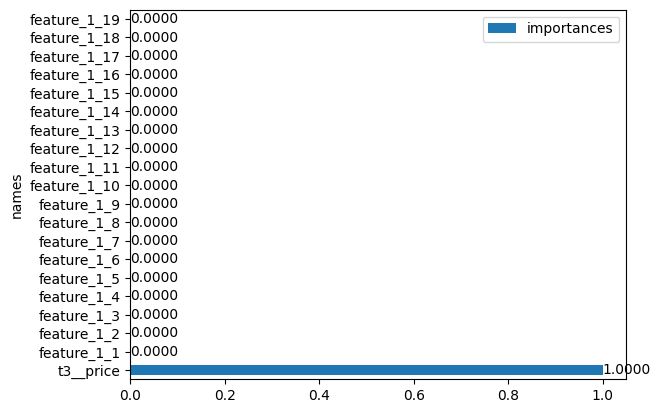

In [31]:
# Plot the top 20 features by importance
ax = (
    pipe.features.sort(by="importances")[:20]
    .to_pandas()
    .plot.barh(y="importances", x="names")
)
_ = ax.bar_label(ax.containers[0], fmt="%.4f")

If you want to see the underlying SQL logic for the top features:

In [32]:
# Top 1
pipe.features.sort(by="importances")[0].sql

```sql

```

This feature is the count of distinct transaction dates for a given customer prior to the churn-prediction timestamp. In simpler terms, "How many separate shopping days has the customer had?"

In [33]:
# Top 2
pipe.features.sort(by="importances")[1].sql

```sql
DROP TABLE IF EXISTS "FEATURE_1_1";

CREATE TABLE "FEATURE_1_1" AS
SELECT COUNT( DISTINCT t2."rating" ) AS "feature_1_1",
       t1.rowid AS rownum
FROM "TRAIN_SHORT__STAGING_TABLE_1" t1
INNER JOIN "REVIEW_RECENT__STAGING_TABLE_4" t2
ON t1."product_id" = t2."product_id"
WHERE t2."review_time" <= t1."timestamp"
AND ( t2."review_time__365_000000_days" > t1."timestamp" OR t2."review_time__365_000000_days" IS NULL )
GROUP BY t1.rowid;
```

---
## 8. Column Importances

Beyond feature importances, getML can also compute *column importances,* showing how each original column (like `rating`, `price`, or `category`) contributed overall to the final model.
This is particularly useful if you want to prune entire columns that have negligible relevance for churn. If, for example `review_time` is extremely low, we might decide
to remove it. This is valuable when dealing with very large data to speed up the pipeline and reduce noise.

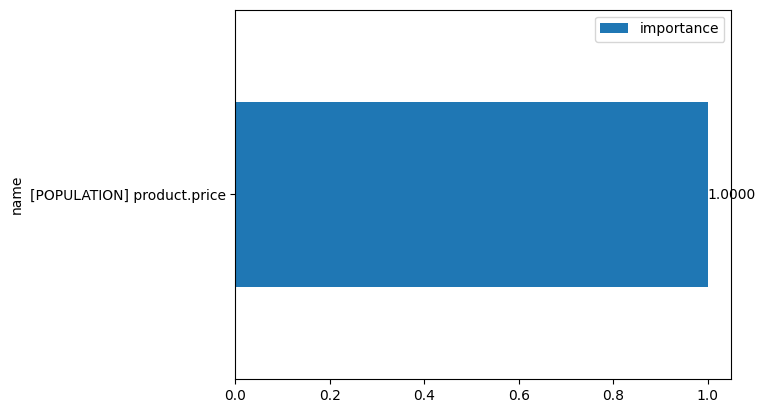

In [34]:
# Plot the top 10 columns by importance
ax = (
    pipe.columns.sort(by="importances")[:10]
    .to_pandas()
    .assign(name=lambda c: c.marker.str.cat(c.table, sep=" ").str.cat(c.name, sep="."))
    .plot.barh(y="importance", x="name")
)
_ = ax.bar_label(ax.containers[0], fmt="%.4f")

---
## 9. Export Features

Now that we have gained a deeper understanding about the drivers of the model's performance, we will squeeze the last bit out of it by optimizing its hyperparameters. 
In order not to generate features for every hyperoptimization run, we generate them now and save them to disk.

In [16]:
pref = "_200"
target = "churn"

# performance on test already above human data science baseline
# but we think that there is more room with an hyperopt on top of extracted features
# next steps: select top x features, export them,
# run lightgbm hyperopt script on 200 most important features 

important_features=pipe.features.sort(by='importance')[:200].names

col_export = important_features + [target]

print(len(pipe.features))

pipe.transform(container.train, df_name="train_transform")[col_export].to_parquet(fname=f"train_transform{pref}")
pipe.transform(container.val,   df_name="val_transform")[col_export].to_parquet(fname=f"val_transform{pref}")
pipe.transform(container.test,  df_name="test_transform")[col_export].to_parquet(fname=f"test_transform{pref}")

511
  Staging... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00
  Preprocessing... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00
  Staging... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00
  Preprocessing... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00
  FastProp: Building subfeatures... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00
  FastProp: Building features... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:58
  Staging... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00
  Preprocessing... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00
  FastProp: Building subfeatures... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00
  FastProp: Building features... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:57



---
## 10. Hyperoptimization

In this section, we train a LightGBM classifier using the features exported from the FastProp pipeline. We leverage Optuna for hyperparameter optimization (hyperopt) to improve performance.

To run the script from terminal:

`python az-item-churn-lgbm_tuning.py`

If you want to run the script in the background and write the output to a log file, use:

`python az-item-churn-lgbm_tuning.py &> az-item-churn-lgbm_tuning.log &`

To run the script from the notebook uncomment the cell below and run it.

In [19]:

#%run az-item-churn-lgbm_tuning.py

---
## 11. Conclusion

In this notebook, we demonstrated how to build a *time-aware, relational* model for item churn prediction using getML. We:
1. Loaded and annotated the data (population, product, review),
2. Defined a DataModel to represent their relationships,
3. Applied getML's FastProp for automated feature engineering using propositionalization,
4. Trained an XGBoostRegressor to predict item-level churn,
5. Evaluated performance on validation and test sets,
6. Analyzed feature and column importances for interpretability.

This provides a solid foundation for churn prediction. While further tuning and feature engineering can enhance accuracy, this analysis highlights the strength of getML in terms of model performance, ease of use, and interpretability with minimal code.

### Next Steps
To explore model tuning or integrate custom predictors with getML's features, check out [hm-item.ipynb](hm-item.ipynb) in this repository, which focuses on item sales prediction using regression techniques.